# Why Customer Segmentation?

Customer segmentation is a technique of dividing customers into groups of individuals who share simmilarities in different ways in such a way that is relevant to marketing. Companies that utilize customer segmentation are under the notion that each customer is different and therefore needs to be marketed differently. Customer Segmentation helps companies to attain the gold standard of marketing: to understand customer preferences on a deep level and in turn help them meet their needs. With the data collected, they can discover and understand valuable segments in order to attain maximum profit. 

## Agenda

1. Exploratory Data Analysis
2. RFM Method Explained
   Data Preparation 
3. K-Means Clustering Explained 
4. Instacart Custoemr Segmentation using K-Means Clustering
5. Marketing Strategy 
6. Suggestions 
7. Conclusion

## Exploratory Data Analysis

### Instacart Dataset

Instacart is a grocery delivery company that operates on an online/mobile platform. A customer can shop at their local grocery store through instacart's app, and instacart will send out a  personal shopper to purchase and deliver your items for you on the same day. The insacart dataset was found online on Kaggle. For every customer, instacart provides between 4 and 100 of their orders, the week and hour of the day the order was made, average number of days in between each orders and more. 

In [469]:
#load libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#load data
asiles = pd.read_csv("/Users/Riniperencsik/Desktop/Customer Segmentation/aisles.csv")
departments = pd.read_csv("/Users/Riniperencsik/Desktop/Customer Segmentation/departments.csv")
order_prior = pd.read_csv("/Users/Riniperencsik/Desktop/Customer Segmentation/order_products__prior.csv")
order_train = pd.read_csv("/Users/Riniperencsik/Desktop/Customer Segmentation/order_products__train.csv")
orders = pd.read_csv("/Users/Riniperencsik/Desktop/Customer Segmentation/orders.csv")
products = pd.read_csv("/Users/Riniperencsik/Desktop/Customer Segmentation/products.csv")

In [262]:
#view the dimensions of each dataset
combined = [asiles, departments, order_prior, order_train, orders, products]
for i in combined: 
    print(i.shape)
del combined

(134, 2)
(21, 2)
(32434489, 4)
(1384617, 4)
(3421083, 7)
(49688, 4)


In [67]:
#display data
asiles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [68]:
departments.head()


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [69]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [71]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [72]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [70]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Explanation of datasets

Note: (*) indicates the variable that each row defines

1. aisles; each row is an aisle
  - vars: *aisle_id; id of the respective aisle 
          aisle; food type aisle (qualitative)
          
          
2. dep; each row is a department
  - vars: department; department/genre of food item (qualitative)
          *aisle_id; id of the respective department 
          
          
3. order_prior; each row is AN item/product of A PRIOR order(s) (multiple rows can represent same order, but different product)
  - vars: *order_id; id of the order which the product belongs to 
          product_id; id of the respective product 
          add_to_cart_order; the order which an item was added to that order (categorical)
          rerodered; binary 1=reordered, 0 =never ordered
          
4. order_train;  each row is AN item/product of the LAST order (multiple rows can represent same order, but different product)
  - vars: order_id; id of the order which the product belongs to 
          *product_id; id of the respective product 
          add_to_cart_order; the order which an item was added to that order (categorical)
          rerodered; binary 1=reordered, 0 =never ordered (binary)

5. orders; each row is a an order for a user (users can have multiple orders)
  - vars: *order_id; unique repsctive order id 
          user_id; unique id to the instacart user 
          eval_set; prior/test/train order (qualitative)
          order_number; order number for the unique user (quantitative)
          order_dow; day of week (is 0 sunday or monday?) (categorical)
          order_hour_of_day; hour of the day (categorical)
          days_since_prior_order; number of days since the last last order (quantitative)

6. products; each row represents a unique product
  - vars: *product_id; unique product id 
          product_name; name of product (qualitative)
          aisle_id; isle id it can be found on 
          department_id; department of product



In [74]:
# convert order_id to factor
order_prior["order_id"] = order_prior["order_id"].astype('category')
#count number of items bought per order
order_size = order_prior.groupby('order_id').count()
del order_size['product_id']
del order_size['add_to_cart_order']
#rename column
order_size = order_size.rename(columns = {"reordered": "size"}) 
order_size.head(5)

,size
order_id,
2,9
3,8
4,13
5,26
6,3


count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: size, dtype: float64


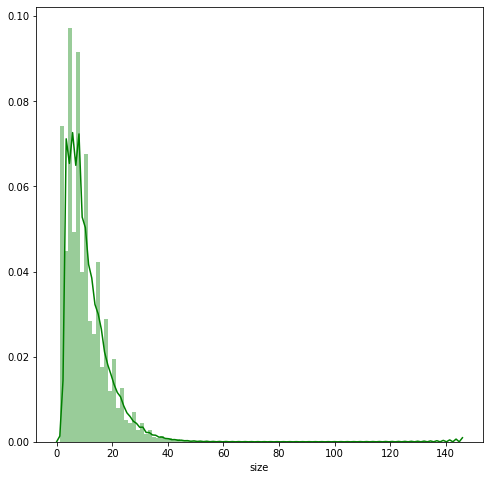

In [11]:
print(order_size['size'].describe())
plt.figure(figsize=(8, 8))
sns.distplot(order_size['size'], color='g', bins=100, hist_kws={'alpha': 0.4});

Here, we can see that the distribution of order size is skewed to the right. The median order size is 8, with the 
maximum outlier being at 145 items!

### Are Orders Larger on the Weekends?

In [258]:
size_day = pd.merge(order_size, orders, on = 'order_id', how = 'left')
size_day.head(10)

,order_id,size,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,9,202279,prior,3,5,9,8.0
1,3,8,205970,prior,16,5,17,12.0
2,4,13,178520,prior,36,1,9,7.0
3,5,26,156122,prior,42,6,16,9.0
4,6,3,22352,prior,4,1,12,30.0
5,7,2,142903,prior,11,2,14,30.0
6,8,1,3107,prior,5,4,6,17.0
7,9,15,139016,prior,14,0,19,5.0
8,10,15,135442,prior,4,6,8,8.0
9,11,5,143742,prior,4,1,19,23.0


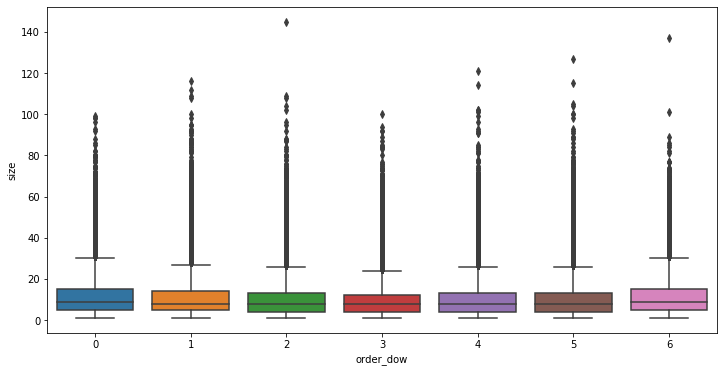

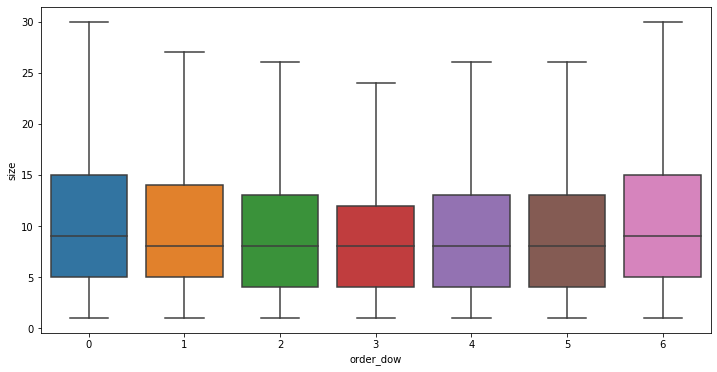

In [259]:
size_day['order_dow'] = size_day['order_dow'].astype('category')
plt.figure(figsize = (12, 6))
sns.boxplot(x='order_dow', y='size', data=size_day, showfliers = True)
plt.figure(figsize = (12, 6))
sns.boxplot(x='order_dow', y='size', data=size_day, showfliers = False)

At this point, we do not know which days of the week correspond to which number. However, we can see that each day 
the week has several outliers so we create another boxplot excluding them in roder to better observe the distribution 
of the quartiles. The median order size from days 1-5 are the same at 8. 1 and 6 have the highest 
at 9 items per order. All days have a minimum order of 1, however the fourth quartiles are highest in item count 
day 0 and 6, indicating that these days might be around the weekend as customers might order larger batches to sustain them
the week. We can therefore hypothesize that the weekends might have the largerst batch orders. To observe this, we can 
look into frequency of orders across all seven days. 

### Which Days Get the Most Orders?

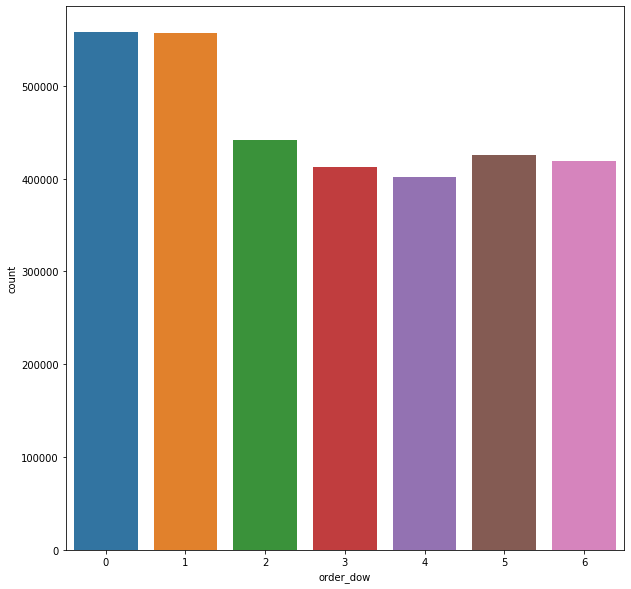

In [59]:
plt.figure( figsize = (10,10))
sns.countplot(x = 'order_dow', data = size_day)

Days 0 and 1 have the highest frequencies of orders, so we can assume 0 is Saturday, 1 is Sunday, 2 is Monday and so on. Days 2-6 have arounf the same number of orders cumulatively. 

### When in the day do customers typically place orders?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1bae255d90>,
      dtype=object)

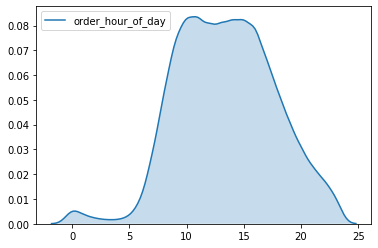

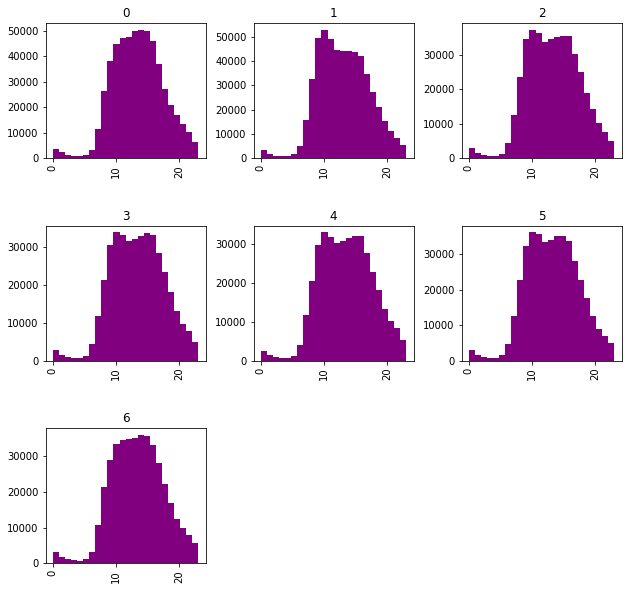

In [91]:
sns.kdeplot(size_day['order_hour_of_day'], shade=True, bw =.6)
size_day.hist(column='order_hour_of_day', by=['order_dow'], figsize=(10,10), color = 'purple', bins = 24)

Based on the first, cummulative plot, the distribution of order count throughout the day appears to be bimodal, with the first peak at 10 am and the second peak at 3 pm as customers prepare for lunch and dinner respectively. Interestingly, on the weekends and Friday, the graphs have more of a unimodal distribution whereas Monday-Thursday are bimodal. 

### How frequently do customers use instacart? Weekly? Monthly?

count    3.008665e+06
mean     1.070724e+01
std      8.954180e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64


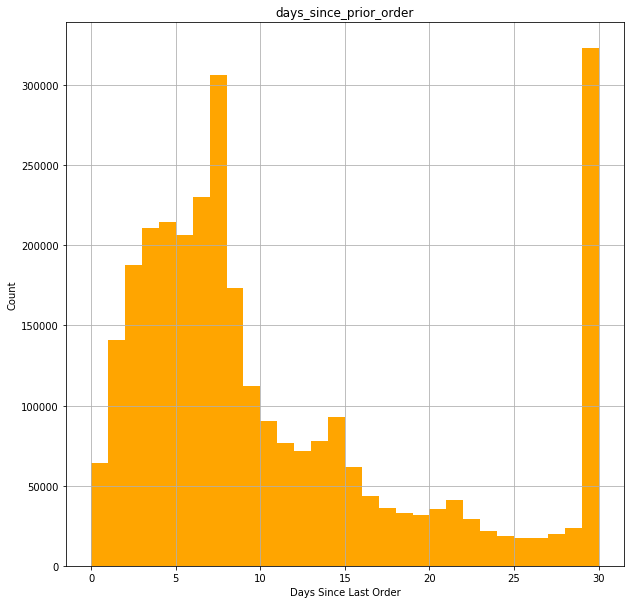

In [488]:
size_day['user_id'] = size_day['user_id'].astype('category')
size_day.hist(column='days_since_prior_order', figsize=(10,10), color = 'orange', bins = 30)
plt.xlabel('Days Since Last Order')
plt.ylabel('Count')
print(size_day['days_since_prior_order'].describe())

The distribution of days since last order is skewed to the right, with a peak at around 7 days and 30 days. The peak and median being at 7 suggests that customers like to use instacart weekly. The peak at 30 days could be a collection of infrequent customers who have orders such that 30+ days have passed since their previous order. 0 days passed could indicate new customers who are making an order for the first time or ordering twice in one day. 

### Are there trends when we group customers by frequency?

In [491]:
freq = size_day.groupby('user_id')[['days_since_prior_order', "size"]].mean()
freq = pd.DataFrame(data=freq)
freq.head()
freq_cat = []
for i in freq['days_since_prior_order']:
    if i < 6: 
        freq_cat.append("multiple/week")
    elif i >= 6 and i < 11:
        freq_cat.append("weekly")
    elif i >= 11 and i < 16: 
        freq_cat.append("bi-weekly")
    elif i >= 16 and i < 25: 
        freq_cat.append("tri-weekly")
    else: 
        freq_cat.append("infrequent")
        
freq['freq_cat'] = freq_cat
freq.head()

,days_since_prior_order,size,freq_cat
user_id,,,
1,19.555556,5.900000,tri-weekly
2,15.230769,13.928571,bi-weekly
3,12.090909,7.333333,bi-weekly
4,13.750000,3.600000,bi-weekly
5,13.333333,9.250000,bi-weekly


Days since prior order can be viewed as the frequency by which a customer uses instacart. We average out the days since prior order for each customer and put them each into a frequency cateogry as follows: 
  
- 0-6(exlusive) = multiple/week
- 6-11 = weekly 
- 11-16 = bi-weekly
- 16-25 = tri-weekly
- 25+ = infrequent

Text(0.5, 1.0, 'Number of Users per Shopping Frequency')

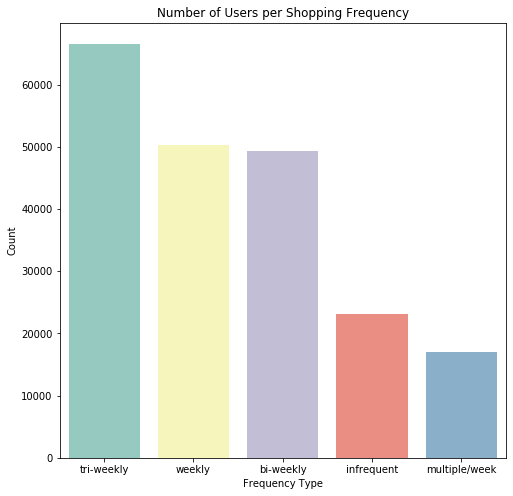

In [492]:
plt.figure(figsize = (8,8))
sns.countplot(x = freq_cat, data = freq, palette = 'Set3', order = freq['freq_cat'].value_counts().index)
plt.xlabel('Frequency Type')
plt.ylabel('Count')
plt.title('Number of Users per Shopping Frequency')

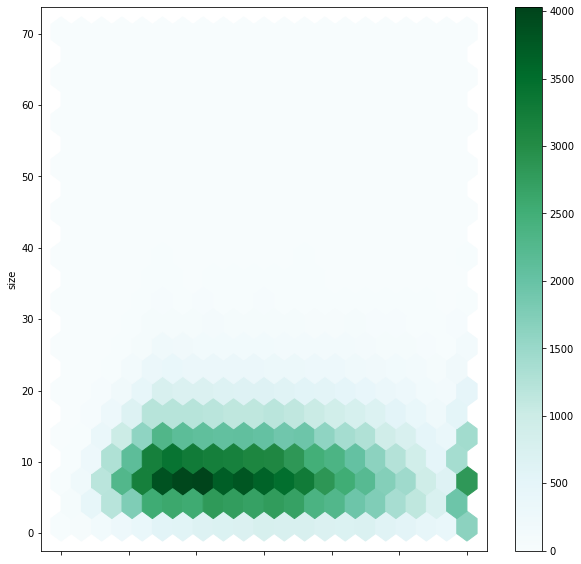

In [164]:
freq.plot.hexbin(x='days_since_prior_order', y='size', gridsize=20, figsize = (10,10))

It can be hypothesized that the less frequent a customer uses instacart, the larger the order will be as they try to order a large enough batch to last them until their next instacart delivery. Above is a hexagonal bin plot of average frequency of a customer vs the average order size of that customer. We use a hexabin plot as an alternative to a scatter plot because the data are too dense to plot individually. A haxabin plots density rather than individual points. We can see that across all average frequencies, most people place an order of around size 8, which happens the be the median of order size across the whole dataset. The density then equally fades out from order size 8. It appears that frequency of orders does not have a relationship to order size, thus suggesting evidence against the hypothesis. 

### Which days do each category like to shop on?

In [166]:
#left join orders with freq by user_id
freq_time = pd.merge(orders, freq, on = 'user_id', how = 'left')
freq_time.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order_x,days_since_prior_order_y,size,freq_cat
0,2539329,1,prior,1,2,8,NaN,19.555556,5.9,tri-weekly
1,2398795,1,prior,2,3,7,15.0,19.555556,5.9,tri-weekly
2,473747,1,prior,3,3,12,21.0,19.555556,5.9,tri-weekly
3,2254736,1,prior,4,4,7,29.0,19.555556,5.9,tri-weekly
4,431534,1,prior,5,4,15,28.0,19.555556,5.9,tri-weekly


<Figure size 1080x576 with 0 Axes>

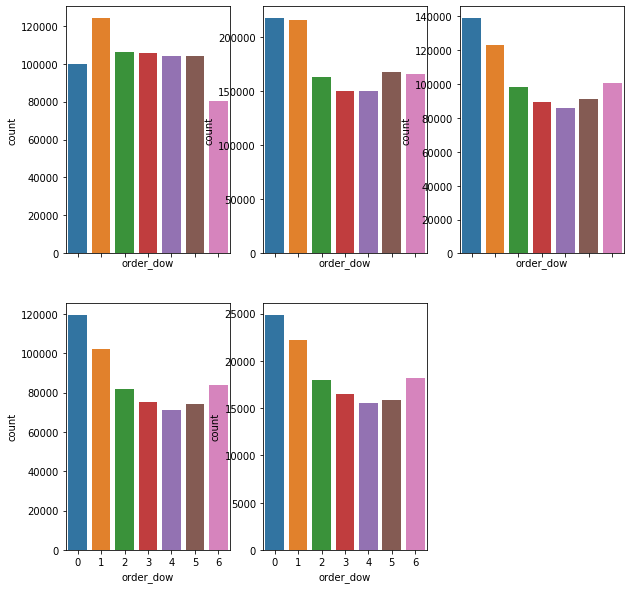

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [487]:
plt.figure(figsize = (15, 8))

f, axes = plt.subplots(2, 3, figsize=(10, 10), sharex=True)
f.delaxes(ax= axes[1,2]) 

a = freq_time["freq_cat"] == 'multiple/week'
b = freq_time[a]
plt.figure(figsize = (4,4))
sns.countplot(x = "order_dow", data = b, ax = axes[0,0])

a = freq_time["freq_cat"] == 'weekly'
b = freq_time[a]
plt.figure(figsize = (4,4))
sns.countplot(x = "order_dow", data = b, ax = axes[0,1])

a = freq_time["freq_cat"] == 'bi-weekly'
b = freq_time[a]
plt.figure(figsize = (4,4))
sns.countplot(x = "order_dow", data = b, ax = axes[0,2])

a = freq_time["freq_cat"] == 'tri-weekly'
b = freq_time[a]
plt.figure(figsize = (4,4))
sns.countplot(x = "order_dow", data = b, ax = axes[1,0])

a = freq_time["freq_cat"] == 'infrequent'
b = freq_time[a]
plt.figure(figsize = (4,4))
sns.countplot(x = "order_dow", data = b, ax = axes[1,1])



There does not appear to be much of a relationship between day of the week of each order when grouping by frequency. However,  the custoemrs who use instacart more than one time a week, on average, have more of an even distribution across days with the expepction of a peak on Sunday and a low on Friday. As for the rest of the shopper frequencies, the graphs look very similar.

### Now lets explore food department variables...

In [194]:
dep = pd.merge(products, departments, on = "department_id", how = "left")
dep = pd.merge(order_prior, dep, on = "product_id", how = 'left')
dep.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce
2,2,9327,3,0,Garlic Powder,104,13,pantry
3,2,45918,4,1,Coconut Butter,19,13,pantry
4,2,30035,5,0,Natural Sweetener,17,13,pantry


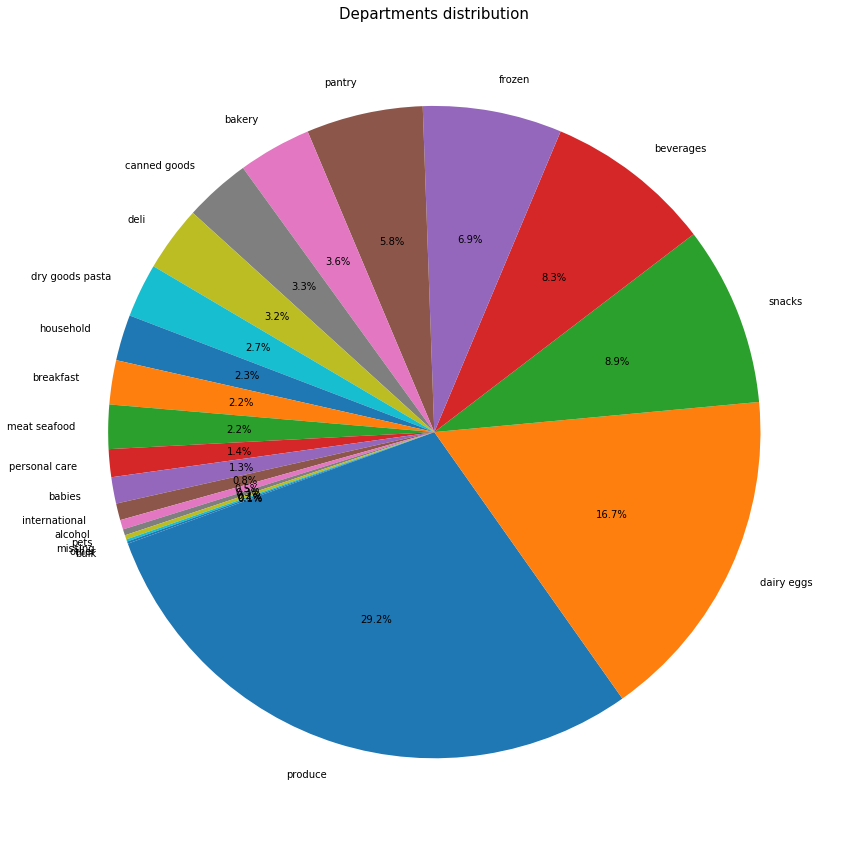

In [196]:
plt.figure(figsize=(15,15))
temp = dep['department'].value_counts()
labels = (np.array(temp.index))
sizes = (np.array((temp / temp.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()


The pie chart above shows the distribution of items ordered by their department. The most department with the most items being ordered is produce with nearly a third of all items, followed by dairy at 16.7%

In [238]:
food = dep['product_name'].value_counts()
food = pd.DataFrame(data=food)
food.reset_index(inplace=True)
food.set_index('index', drop=False, inplace=True)
food.head()

,index,product_name
index,,
Banana,Banana,472565
Bag of Organic Bananas,Bag of Organic Bananas,379450
Organic Strawberries,Organic Strawberries,264683
Organic Baby Spinach,Organic Baby Spinach,241921
Organic Hass Avocado,Organic Hass Avocado,213584


Text(0.5, 1.0, 'Top Ten most Ordered Food Items')

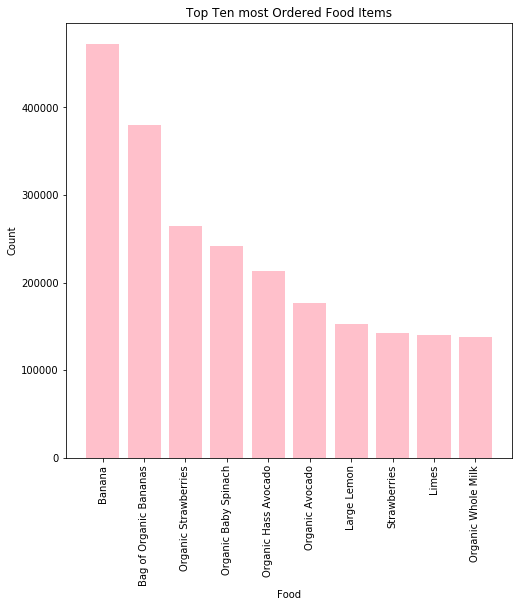

In [494]:
plt.figure(figsize = (8,8))
plt.bar('index', 'product_name', data = food[0:10], color = 'pink')
plt.xticks([0,1,2,3,4,5,6,7,8,9],food['index'],rotation=90)
plt.xlabel('Food')
plt.ylabel('Count')
plt.title('Top Ten most Ordered Food Items')

From the chart, we can see the top ten most popular food items that instacart shoppers buy, with banana in the lead followed by a bag of organic bananas and strawberries.

## RFM Method Explained

There are numerous different ways to do customer segmentation depending on what you want to acheive. For example, you might want to segment customers based on the types of items they purchase if the goal is to properly advertise certain food items. Another use of customer segmentation is to increase customer retention rate. A popular method of segmenting customers is RFM.R refers to the recency of which a customer made his last order, F referes to the frequency by which customers make orders, and M referes to Monetary value, ie how much revenue customers are bringing in. Recency, Frequency and Monetary Value of a customer are measures that have been proven to be a predictor of a customer's future behavior, such as their willingness to engage in marketing tactics Based on the variety of degrees of recency, frequency, and monetary value, we can group similar customers together in order to customize marketing strategy. For example, we might want to group customers with high monetary value, but low frequency and recency so that we can focus on incentivizing them to make another order rather than incentivizing them to purchase more items per order when they have already shown a willingess to do so. 

Unfortunately, the instacart dataset has been thoroughly anonymized and therefore lacks certain crucial features that we would need to create our three RFM variables. However, with simple feature engineering, we can create new variables that closely imitate the original RFM: 

-Recency: we do not have access to specific date times so in place of recency we will calculate total number of orders for each customer
-Frequency: to calculate this variable, we can average the lag time between each of a customer's orders. 
-Monetary value: instacart does not provide information on the amount of money they generate for each batch, but we can assume that the more items in the order, the larger revenue they recieve. Therefore, for each customer we can create a variable that averages the typical size of their order. 

## Data Preparation

In [263]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [264]:
order_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


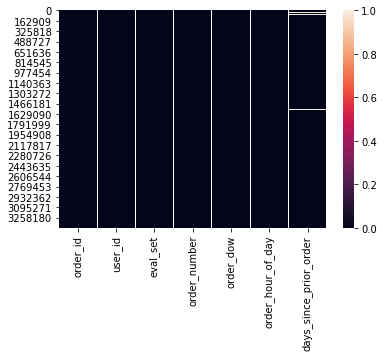

In [266]:
#check for missing values in orders 
sns.heatmap(orders.isnull(), cbar = True)

days_since_prior_order is the only variable with missing data. Lets take a look at these observations.

In [274]:
print(len(orders[orders['days_since_prior_order'].isnull()]))

206209


There are 206,209 missing cells for the variable. Since the data includes orders of over 200,000 instacart customers, we can guess that the reason this data is missing is because these were the first order of each customer, and therefore the number of days since prior order is not applicable. As such, to deal with this null value, we will simply leave it out when calculating the mean.

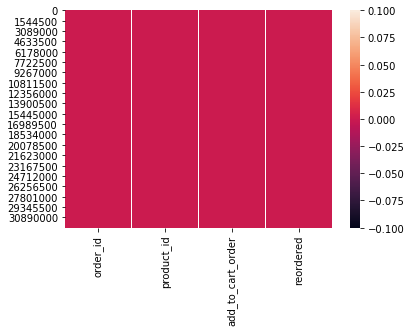

In [273]:
#check for missing values in order_prior
sns.heatmap(order_prior.isnull(), cbar = True)

Based on the heat map, order_prior has no missing values.

Now, it is time to create the dataset for K-Means by merging the orders and order_prior dataset. First, we will group order_prior by order_id and cound count the number of items in each order. Then, we will merge the data with orders to pair rach order_id with the instacart customer. Lastly, we will extract each user's total orders, average order size, adn average lag using the mean.

In [498]:
data = pd.DataFrame(order_prior.groupby('order_id')['order_id'].value_counts())
data = data.rename(columns = {"order_id": "order_size"}) 
data.reset_index(level=1, drop=True,inplace=True)
data_joined = pd.merge(data, orders, on = 'order_id', how = 'left')

Now, we will standardize the variables becasue K-means uses the Euclidean distance so the scale of each feature will have a significant impact. Standardizing all variables allows them to be equally considered by the algorithm. We scale them to have a mean of 0 and standard deviation of 1.

In [418]:
data_joined1 = data_joined.groupby('user_id').agg(total_orders = ('user_id',"count"), 
                                                  avg_order_size = ('order_size', "mean"),
                                                  avg_lag = ('days_since_prior_order',"mean"))
data_joined1.reset_index(level=0, inplace=True)
data_joined1['avg_lag_scaled'] = preprocessing.scale(data_joined1['avg_lag'])
data_joined1['avg_order_size_scaled'] = preprocessing.scale(data_joined1['avg_order_size'])
data_joined1['total_orders_scaled'] = preprocessing.scale(data_joined1['total_orders'])
data_joined1.head()

,user_id,total_orders,avg_order_size,avg_lag,avg_lag_scaled,avg_order_size_scaled,total_orders_scaled
0,1,10,5.900000,19.555556,0.611676,-0.690978,-0.335662
1,2,14,13.928571,15.230769,0.003003,0.678255,-0.095490
2,3,12,7.333333,12.090909,-0.438904,-0.446530,-0.215576
3,4,5,3.600000,13.750000,-0.205402,-1.083231,-0.635877
4,5,4,9.250000,13.333333,-0.264044,-0.119652,-0.695920


## K-Means Clustering Explained 

### Clustering

When creating clusters, we strive to find subgroups with similar characteristics within the data such that the data points in each cluster are as similar as possible, and as different as possible from other clusetrs. The similarity within each cluster is mesured by the Euclidean-based distance or correlation based distance. Clustering is an unsupervised Machine Learning method since we do not have a truth to compare the output of clustering algorithm to in order to evaluate the performance. 

### K-Means Algorithm

K-Means clustering is one of the most popular and easy-to-understand unsupervised machine learning algorithms. 
1. choose the number of k clsuetrs
2. shuffle the dataset and randomly select k data points for the cluster centroids
3. measure the sum distance between the first data points and the k initial clusters
4. assign the first data point to the nearest cluster
5. now, do steps 4 and 5 to all the data points
6. calculate the mean of each cluster
7. repeat measuring and clustering process, this time using the mean values
8. when the clustering does not change during the last iteration, we are done

## Instacart Customer Segmentation Using K-Means Clustering

Now we are going to apply the K-Means Clustering algorithm to the instacart dataset to cluster customers based of RFM. First, we need to choose the number of clusters K. We will do this by applying the elbow method. The elbow method works by running k-means clustering on the data for a range of k values (in our case, 1-10) and then for each k, an average score is calculated for all clusters. In this case, we will use inertia which is the sum of squared distances from each point to its assigned center. Essentially, with each new k cluster we add, the total variation within each cluster decreases. 

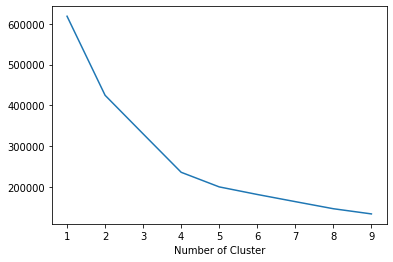

In [474]:
sse = {}
#below is a dataset of user_id as a column index and total_orders as a regular column
total_score = data_joined1[['total_orders_scaled', 'avg_lag_scaled', 'avg_order_size_scaled']]
#below we are trying to find the optimal number of clusters by fitting a k-means to the data
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, max_iter=1000).fit(total_score)
    total_score['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Cluster")
plt.show()

Above we see that the elbow bends at k = 4 clusters before the marginal decrease in variation starts becoming insiginficant.

In [458]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_joined1[['total_orders_scaled', 'avg_lag_scaled', 'avg_order_size_scaled']])
data_joined1['TotalCluster'] = kmeans.predict(data_joined1[['total_orders_scaled', 'avg_lag_scaled', 'avg_order_size_scaled']])

In [475]:
data_joined1.groupby('TotalCluster')[['avg_order_size', 'avg_lag', 'total_orders']].mean()

,avg_order_size,avg_lag,total_orders
TotalCluster,,,
0,10.039630,6.447888,54.603638
1,7.688506,11.170172,14.025388
2,7.423529,22.997060,6.397266
3,18.946884,15.950170,11.519560


Above, we have the means of each cluster across each customers average order size, average lag, and total orders. However, to get a better visualization of where these clusters are located we will create a 3D plot.

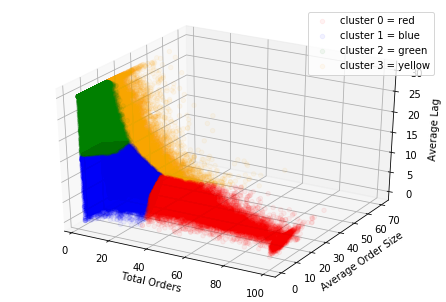

In [468]:
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(data_joined1[data_joined1['TotalCluster']==0][['total_orders']],data_joined1[data_joined1['TotalCluster']==0][['avg_order_size']],data_joined1[data_joined1['TotalCluster']==0][['avg_lag']],color='red', alpha = .05, label = 'cluster 0 = red')
ax.scatter(data_joined1[data_joined1['TotalCluster']==1][['total_orders']],data_joined1[data_joined1['TotalCluster']==1][['avg_order_size']],data_joined1[data_joined1['TotalCluster']==1][['avg_lag']],color='blue', alpha = .05, label = 'cluster 1 = blue')
ax.scatter(data_joined1[data_joined1['TotalCluster']==2][['total_orders']],data_joined1[data_joined1['TotalCluster']==2][['avg_order_size']],data_joined1[data_joined1['TotalCluster']==2][['avg_lag']],color='green', alpha = .05,label = 'cluster 2 = green')
ax.scatter(data_joined1[data_joined1['TotalCluster']==3][['total_orders']],data_joined1[data_joined1['TotalCluster']==3][['avg_order_size']],data_joined1[data_joined1['TotalCluster']==3][['avg_lag']],color='orange', alpha = .05, label = 'cluster 3 = yellow')

ax.set_xlabel("Total Orders")
ax.set_ylabel("Average Order Size")
ax.set_zlabel("Average Lag")
plt.legend(loc="upper right")
plt.show()

The 3D plot above shows that the three segments are clearly separated from each other. The green cluster has low range in all three variables. These are the instacart's worst customers who purchase the least total orders, lowest average size and high lag. The blue cluster comprises of cutsomers with low lag time, low-to-medium number of orders and a relatively low average size of orders. This clsuter has relatively low range. The red cluster has a high range in the total number of orders of each customer. However, they have low range in average lag time with low values which is a good indicator. The yellow cluster has a high range of lag times but tend to have the largest order size than the other clusters.

Text(0, 0.5, 'Value')

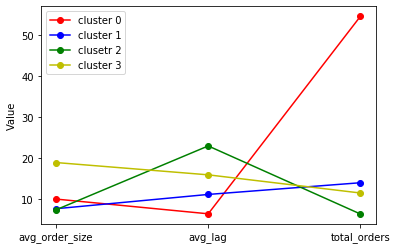

In [495]:
x_axis = ['avg_order_size', 'avg_lag', 'total_orders']
cluster0 = [10.039, 6.447, 54.603]
cluster1 = [7.688, 11.170,14.025]
cluster2 = [7.423,22.997,6.397]
cluster3 = [18.9468,15.950,11.519]
line1 = plt.plot(x_axis, cluster0,'ro-',label='cluster 0')
line2 = plt.plot(x_axis, cluster1,'bo-',label='cluster 1') 
line3 = plt.plot(x_axis, cluster2,'go-',label='clusetr 2')
line4 = plt.plot(x_axis, cluster3,'yo-',label='cluster 3')
plt.legend(loc="upper left")
plt.ylabel('Value')

The one dimensional graph is created using the mean of each attribute per cluster. With this multi-line plot, we can more consiely summarize each cluster to form a marketing strategy. 

## Marketing Strategy

After segmenting the customers, we can now devise a marketing startegy to better suit the type of customers. Having these four segments, we can now better personalize the offers/ marketing strategies to beccome more relevant to the customer at hand. 
- Cluster 0: Instacart’s most loyal customers. These customers place an extreme amount of orders from Instacart. Instacart must leverage loyalty programs in order to spur repeat sales. An example of a loyalty program could be to give shoppers ten cents back for every item they purchase. Additionally, Instacart could consider rewarding these customers with free deliveries or other benefits. 
- Cluster 1: Instacart’s most faithful customers. These customers place a good amount of orders but do not purchase a lot of items. For this segment, Instacart should focus on increasing monetization through product recommendations based on the customer’s past purchases. To further increase order size, Instacart should create incentives to spending thresholds. This might include a five dollar off coupon for purchasing twenty items. 
- Cluster 2: Instacart’s worst customers with low frequency, low number of orders, and low monetary value. These customers do not show a willingness to place large orders in a frequent manner. As a marketing strategy, Instacart can give them discounts on costs of delivery to increase their willingness to order more items. Furthermore, in order to increase frequency, Instacart can put expiration dates on these discounts with decreasing window sizes to instill a sense of urgency within the customer, which will therefore increase frequency.
- Cluster 3: Instacart’s highest paying customers. These customers  have the largest average number of items per order, therefore generating the most revenue for Instacart. However, their total number of orders is not too high and they have a relatively high lag time between each order. Instacart should primarily focus on increasing frequency by offering free/discounted delivery coupons within a specified window to create a sense of urgency, similar to the marketing strategy for cluster 2. However, Instacart should not offer discounts for items as they have already shown a high willingness to pay.

## Suggestions

After implementing these marketing strategies, instacart should continue collecting data in order to assess the effictiveness of each strategy on each type of customer. They should pay attention to how customers react to the deals they are given. That way, if a strategy proves to be ineffecitve on a certain customer, instacart can adjust their strategy and try a different method. Aditionally, they can track which deals are successful so that they can shift their focus to improving other areas for the customer. For example, if instacart is sucessful in increasing a customer's recency score they should shift their focus towards increasing a different area such as frequency. 

## Conclusion

Customer segmentation using the RFM method is vital for instacart's marketing strategy because it leverages a customer's behavioral information. With the deeper understanding that the four segments provide instacart with, they can better personalize offers to meet the needs of their customers. Furthermore, a more customized offer based on the shopping tendencies of each customer allows instacart to optimize the allocation of their deals. Now, they can better understand which types of deals will generate long term revenue for each customers and therefore limit the initial losses they take on when offering incentives. Customer segmentation gives instacart greater assurance that their offers are relevant to each customer and driving measurable results when conducting a follow up analysis. 